In [1]:
using Distributions, Random, Plots
using LinearAlgebra, StatsFuns, QuadGK, HypothesisTests

In [2]:
### Simulated auction set-up

# Auction parameters
Random.seed!(6789998212);
I = 10;   # Number of bidders
N = 1000; # Number of auctions

# Draw valuations and calculate bids
v = randn(N,I); # Draw valuations from N(0,1)
b = v;          # Optimal bid strategy for SPA

In [3]:
### Second-price auction

# Store winning bid and price paid
b_sort = sort(b, dims = 2);
spa = [b_sort[:,I] b_sort[:,I-1]];

# Simulated mean highest and second-highest bid 
println("Simulated highest and second-highest bid: ", mean(spa, dims = 1))

# Analytic formula using quadrature
f = Normal(0,1)
b_1(x) = I * x * pdf(f,x) * cdf(f,x)^(I-1)
b_2(x) = I * (I-1) * x * pdf(f,x) * cdf(f,x)^(I-2) * (1-cdf(f,x))

Eb_1 = quadgk(x -> b_1(x), -Inf, +Inf)[1]
Eb_2 = quadgk(x -> b_2(x), -Inf, +Inf)[1]

println("Theoretical highest and second-highest bid: [$Eb_1, $Eb_2]")

Simulated highest and second-highest bid: [1.5073422199326407 0.9759201851521684]
Theoretical highest and second-highest bid: [1.5387527308351685, 1.0013570445747912]


In [4]:
### eBay auction

# Run simulated auction
r  = -100000;        # Reserve (starting) price
h₀ = ones(N,I) .* r; # What each bidder observes when they arrive
c  = ones(N,I) .* r; # Highest submitted cutoff  
h₁ = ones(N,I) .* r; # Standing price after submitted cutoff
np = zeros(N);       # Number of participants
for n = 1:N
    for i = 1:I
        if i > 1
            h₀[n,i] = h₁[n,i-1]  # Update initial price
            if v[n,i] > h₀[n,i]  # Bidder enters if valuation above observed price
                np[n]  += 1
                c[n,i]  = max(c[n,i-1],v[n,i]) # Current highest cutoff updates
                h₁[n,i] = min(c[n,i-1],v[n,i]) # Standing price updates
            else                 # Bidder stays out
                c[n,i]  = c[n,i-1]
                h₁[n,i] = h₀[n,i]
            end
        else
            if v[n,1] > h₀[n,1]
                np[n]  += 1
                c[n,1]  = v[n,1]
            end
        end
    end
end

# Store results (highest bid, price paid, number of participants)
ebay = [c[:,I] h₁[:,I] np[:]];

# Collect bids submitted in each auction
ebay_bids = []
for n = 1:N
    # Submitted bids in any auction are superset of highest cutoffs and active prices
    # Cutoffs are clearly submitted bids; an active price may have raised the price but been immediately outbid
    bids_temp = union(h₁[n,:],c[n,:])
    push!(ebay_bids,bids_temp[bids_temp .> r])
end

Simulated highest and second-highest bid: [1.5073422199326407, 0.9759201851521684]


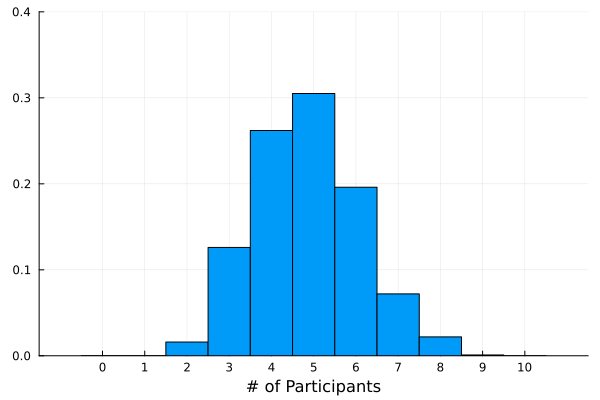

Mean (across auctions) of mean submitted bid: 0.517890336535401
Variance (across auctions) of mean submitted bid: 0.19490754819993106


One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.51789
    95% confidence interval: (0.4905, 0.5453)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations:   1000
    t-statistic:              37.09569210657131
    degrees of freedom:       999
    empirical standard error: 0.013960929345854132


In [5]:
# Simulated mean highest and second-highest bid 
println("Simulated highest and second-highest bid: ", mean(ebay, dims = 1)[1:2])

# Histogram of participants in each auction
display(histogram(ebay[:,3],
            bins = 0:1:I+1,
            normalize = true,
            xticks = (0.5:1:I+0.5, 0:1:I), 
            xlimits = (-1,I+2),
            ylimits = (0,0.4),
            legend = false,
            xlabel = "# of Participants"));
            
# Mean and variance of submitted bids
println("Mean (across auctions) of mean submitted bid: ", mean(mean.(ebay_bids)))
println("Variance (across auctions) of mean submitted bid: ",var(mean.(ebay_bids)))

# Test null that mean bid is 0
OneSampleTTest(mean.(ebay_bids), 0)

In [6]:
### Song (2004) estimate bid distribution